In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost 
import math
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import explained_variance_score, mean_squared_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

file_house = "/home/malick/Bureau/Stage_Projet_RTS/usecase/x(g)boost/house_data.csv"

df = pd.read_csv(file_house)
#Col_obj = list(df.select_dtypes(include='object').columns)
#df[Col_obj] =df[Col_obj].astype(str) 

In [9]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [10]:
print(df.values.shape)
print(df.dtypes.unique())

(21613, 21)
[dtype('int64') dtype('O') dtype('float64')]


In [11]:
df.select_dtypes(include=['O']).columns.tolist()

['date']

In [12]:
# Check any number of columns with NaN
print(df.isnull().any(axis=0).sum(), ' / ', len(df.columns))

# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

0  /  21
0  /  21613


In [13]:
# Correlations between features and target
features = df.iloc[:,3:].columns.tolist()
target = df.iloc[:,2].name

data = df

correlations = {}

for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


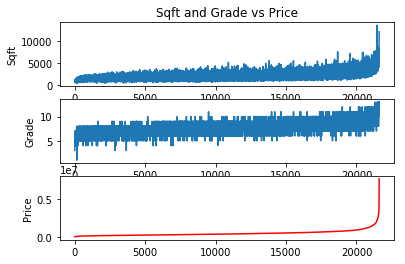

In [51]:
y = data.loc[:,['sqft_living','grade',target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

%matplotlib inline
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Sqft and Grade vs Price')
plt.ylabel('Sqft')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Grade')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Price")

plt.show()

In [32]:
########Predicting House Sales Prices########

In [14]:
# Train a simple linear regression model
regr = linear_model.LinearRegression()
new_data = data.copy()
new_data.drop(["id","date","price"], axis='columns', inplace=True)

In [59]:
new_data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [15]:
X = new_data
y = data.price
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.25)

In [16]:
regr.fit(X_train, y_train)
regr.score(X_test,y_test)

0.6878313914039986

In [17]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 200288.51


In [22]:
# Let's try XGboost algorithm to see if we can get better results

X = new_data
y = data.price
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)



#xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,
#                           colsample_bytree=1, max_depth=7)
#eval_set = [(X_test, y_test)]
#xgb.fit(X_train,y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

/home/malick/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/malick/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', subsample = 1, colsample_bytree = 1, learning_rate = 0.1,
                max_depth = 8, alpha = 10, gamma=0, n_estimators = 200)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[16:17:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [63]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 121881.776833


In [73]:
#####Cross Validation using XGBoost
params = {"objective":"reg: squarederror",'colsample_bytree': 1,'learning_rate': 0.1,
                'max_depth': 8, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=4,
                    num_boost_round=150, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[15:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [74]:
cv_results.head(10)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,592326.468750,1726.864230,593302.671875,4826.099629
1,537733.546875,1559.984875,539644.593750,4304.697612
2,488624.828125,1366.845981,491423.992188,3436.422518
3,444437.859375,1333.958082,448378.953125,2703.621896
4,404767.304688,1222.063661,409800.890625,2063.570721
5,368979.546875,1159.548618,375329.539062,1776.058031
6,336892.437500,1099.657555,344978.890625,1514.730790
7,308043.414062,1077.825803,317369.679688,1788.031521
8,282170.148438,1022.207101,292936.570312,1953.169951
9,258995.804688,966.493249,271470.640625,2112.751875


In [75]:
print((cv_results["test-rmse-mean"]).tail(1))

149    123082.59961
Name: test-rmse-mean, dtype: float64


In [85]:
#### Visualize Boosting Trees and Feature Importance

params = {"objective":"reg: squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

xgb.plot_tree(xg_reg,num_trees=1)
plt.rcParams['figure.figsize'] = [100, 20]
plt.show()



XGBoostError: [16:12:58] /workspace/src/objective/objective.cc:23: Unknown objective function reg: squarederror
Stack trace:
  [bt] (0) /home/malick/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(xgboost::ObjFunction::Create(std::string const&)+0x6d0) [0x7f3ad94b6070]
  [bt] (1) /home/malick/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::LazyInitModel()+0x3c1) [0x7f3ad945bff1]
  [bt] (2) /home/malick/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(XGBoosterUpdateOneIter+0x52) [0x7f3ad93c3ac2]
  [bt] (3) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f3b2032adae]
  [bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7f3b2032a71f]
  [bt] (5) /usr/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2b4) [0x7f3b2053ec64]
  [bt] (6) /usr/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x122e3) [0x7f3b2053f2e3]
  [bt] (7) /usr/bin/python(_PyObject_FastCallKeywords+0x19c) [0x57ec0c]
  [bt] (8) /usr/bin/python() [0x4f88ba]

